# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


import re
import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import functools as ft

In [2]:
# create a Spark session

spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
spark.sparkContext.getConf().getAll()


[('spark.driver.port', '33113'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host',
  '1ef853f74221f4edf9c887be9ac13b7a2d3c2b18-6c58fdd7b9-h4v5l'),
 ('spark.app.id', 'local-1695886871804'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'Sparkify Project')]

In [4]:
# load in the dataset
df = spark.read.json("mini_sparkify_event_data.json")

# let's take a look at the columns in the data 

df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [5]:
type(df)

pyspark.sql.dataframe.DataFrame

In [6]:
df.count()

286500

In [7]:
# let's take a look at the first row
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [8]:
# how many Users are there ?

df.select("userId").distinct().count()

226

In [9]:
# we wanna see the empty string for users and remove it

df = df.filter(df['userId'] != "")
df.select("userId").distinct().count()



225

In [10]:
# Let's make data for the Churn column below to count users who Churn


churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_churn = df.withColumn('churn_event', churn_event('page'))

windowval = Window.partitionBy('userId')
df_churn = df_churn.withColumn('churn', max('churn_event').over(windowval))

df_churn.select(['userId', 'churn']).dropDuplicates().show(20)

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



In [11]:

#print(df_churn.shape)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [12]:
# lets see the null values for each column
#df.isna().sum()


I don't see any missing values in user Id or SessionID so we move on and explore the dataset

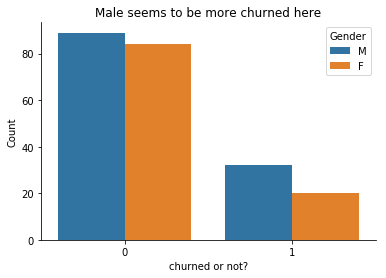

In [13]:
# so now we wanna see who churned from users by gender 

gender_churn_pd = df_churn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()


ax = sns.barplot(x='churn', y='count', hue='gender', data=gender_churn_pd)
plt.xlabel('churned or not?')
plt.ylabel('Count')
plt.legend(title='Gender', loc='best')
plt.title('Male seems to be more churned here')
sns.despine(ax=ax);

In [14]:
gender_churn_pd

,churn,gender,count
0,0,M,89
1,0,F,84
2,1,F,20
3,1,M,32


Clearly there's a diffrence between genders in regards to churn users and not.

In [15]:
Perc = 52/(52+173)*100
print("Percentage of users who Churn:")
Perc

Percentage of users who Churn:


23.11111111111111

In [16]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

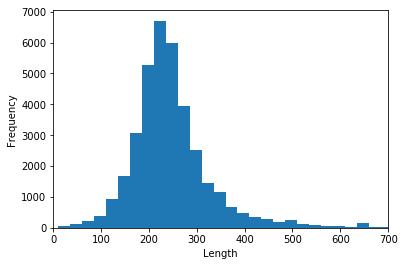

In [17]:
# now we wanna see the length distribution from users who churn to not

df_len_1 = df_churn.filter(df_churn.churn == 1).select(df_churn['length']).toPandas().dropna()#.plot(kind = "hist", xlim = (0,500))#.sort_values(by = "length",ascending = False)

bin_edges = np.arange (10, df_len_1['length'].max()+25, 25)
plt.hist(data = df_len_1, x = 'length', bins = bin_edges)
plt.xlim(0,700)
plt.xlabel('Length')
plt.ylabel('Frequency');


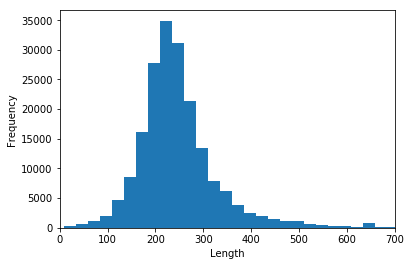

In [18]:
df_len_0 = df_churn.filter(df_churn.churn == 0).select(df_churn['length']).toPandas().dropna()#.plot(kind = "hist", xlim = (0,500))#.sort_values(by = "length",ascending = False)

bin_edges = np.arange (10, df_len_0['length'].max()+25, 25)
plt.hist(data = df_len_0, x = 'length', bins = bin_edges)
plt.xlim(0,700)
plt.xlabel('Length')
plt.ylabel('Frequency');

it appears that the same length for both who stayed and not so this column maybe it's not ideal to build the model on

In [19]:
# let's try and explore the level column

df_churn.select(['userId', 'churn', 'level']).dropDuplicates().groupBy('level','churn').count().toPandas()

,level,churn,count
0,paid,0,129
1,free,0,149
2,paid,1,36
3,free,1,46


Text(0.5,1,'The Free users are more likely to churn than the paid ones')

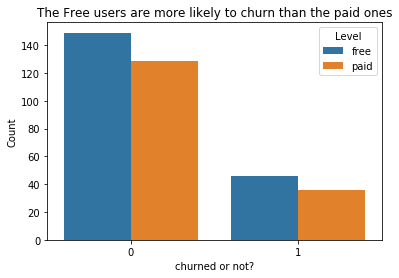

In [20]:
level_df_1 = df_churn.select(['userId', 'churn', 'level']).dropDuplicates().groupby(["churn", "level"]).count().toPandas()#.plot(kind = "bar")#.sort_values(by = "length",ascending = False)


ax_level = sns.barplot(x='churn', y='count', hue='level', data=level_df_1)
plt.xlabel('churned or not?')
plt.ylabel('Count')
plt.legend(title='Level', loc='best')
plt.title('The Free users are more likely to churn than the paid ones')

The plot above shows that the free users are more likely to churn, so there's a diffrence between a "paid" user and a "free" user, this feature would help us in building the model.

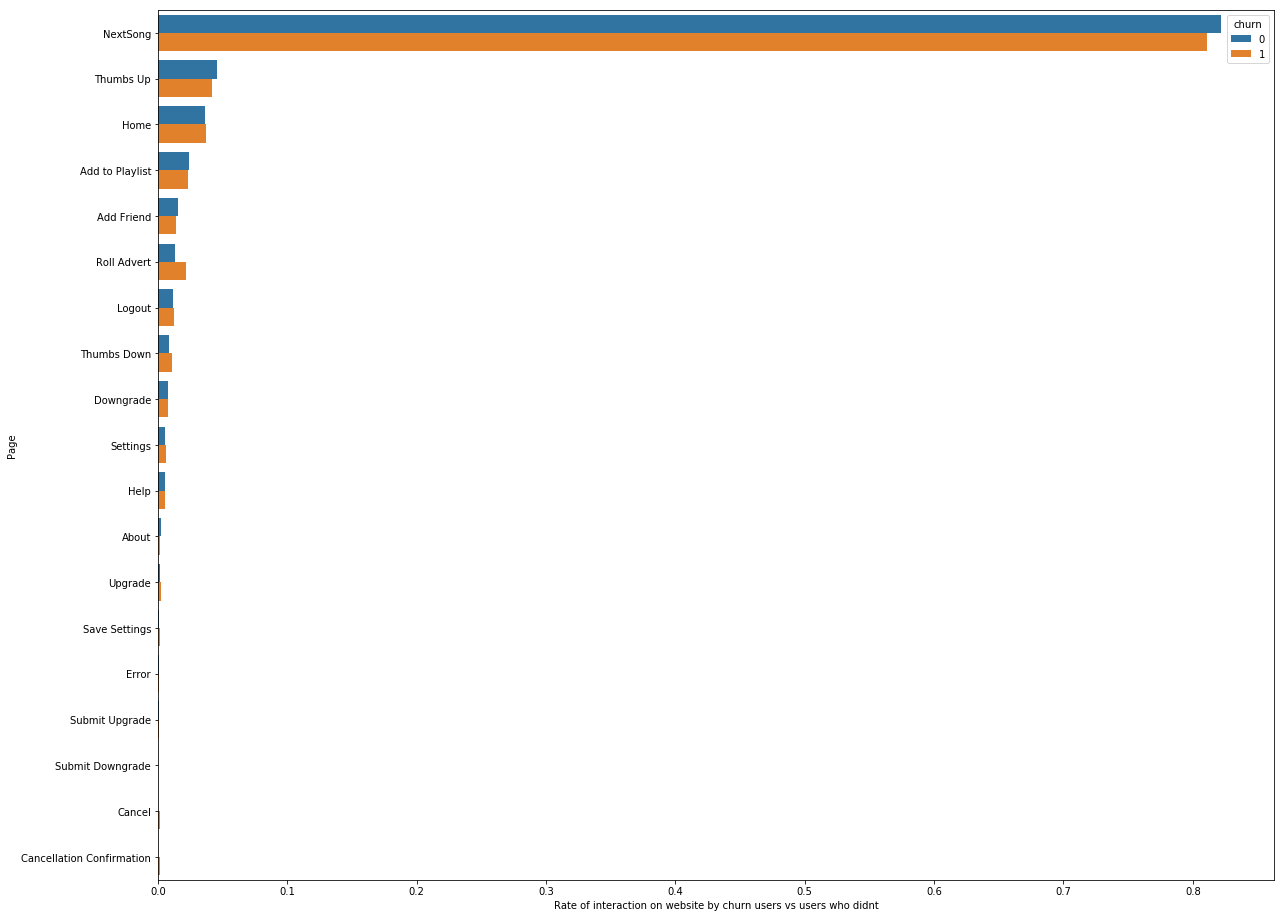

In [21]:
# now let's try to work on the Page column

df_page = df_churn.select(['userId', 'churn', 'page']).groupby(["churn", "page"]).count().toPandas().sort_values(by = "count",ascending = False)

# create counts for those who churned and those who stayed
churn_count =  df_page[df_page['churn'] == 1].sum() 
stay_count =  df_page[df_page['churn'] == 0].sum()

# calculate the rate 

df_page['rate'] = np.where(
    df_page['churn'] == 0, df_page['count']/stay_count['count'], np.where(
    df_page['churn'] == 1, df_page['count']/churn_count['count'],df_page['count']/churn_count['count'])) 

plt.figure(figsize=[20,16])

ax_page = sns.barplot(x='rate', y='page', hue='churn', data=df_page)
plt.xlabel('Rate of interaction on website by churn users vs users who didnt')
plt.ylabel('Page')
plt.legend(title='churn', loc='best')

We can see from the above plot that the user who skip to next song have the most interaction,we also see that that the roll advert action has more churn users,also for the downgrade action.

In [22]:
# now let's work on the user agent or the operating system we will use regular expression here

map = {'Compatible': 'Windows', 'Ipad': 'iPad', 'Iphone': 'iPhone', 'Macintosh': 'Mac',  
       'Windows nt 5.1': 'Windows', 'Windows nt 6.0': 'Windows', 'Windows nt 6.1': 'Windows', 
       'Windows nt 6.2': 'Windows',  'Windows nt 6.3': 'Windows', 'X11': 'Linux'}

get_operating_sys = udf(lambda x: map[re.findall('\(([^\)]*)\)', x)[0].split(';')[0].capitalize()])
df_system = df_churn.withColumn('operating_system', get_operating_sys(df_churn.userAgent))
df_system.select('operating_system').distinct().show(5)

+----------------+
|operating_system|
+----------------+
|            iPad|
|          iPhone|
|           Linux|
|             Mac|
|         Windows|
+----------------+



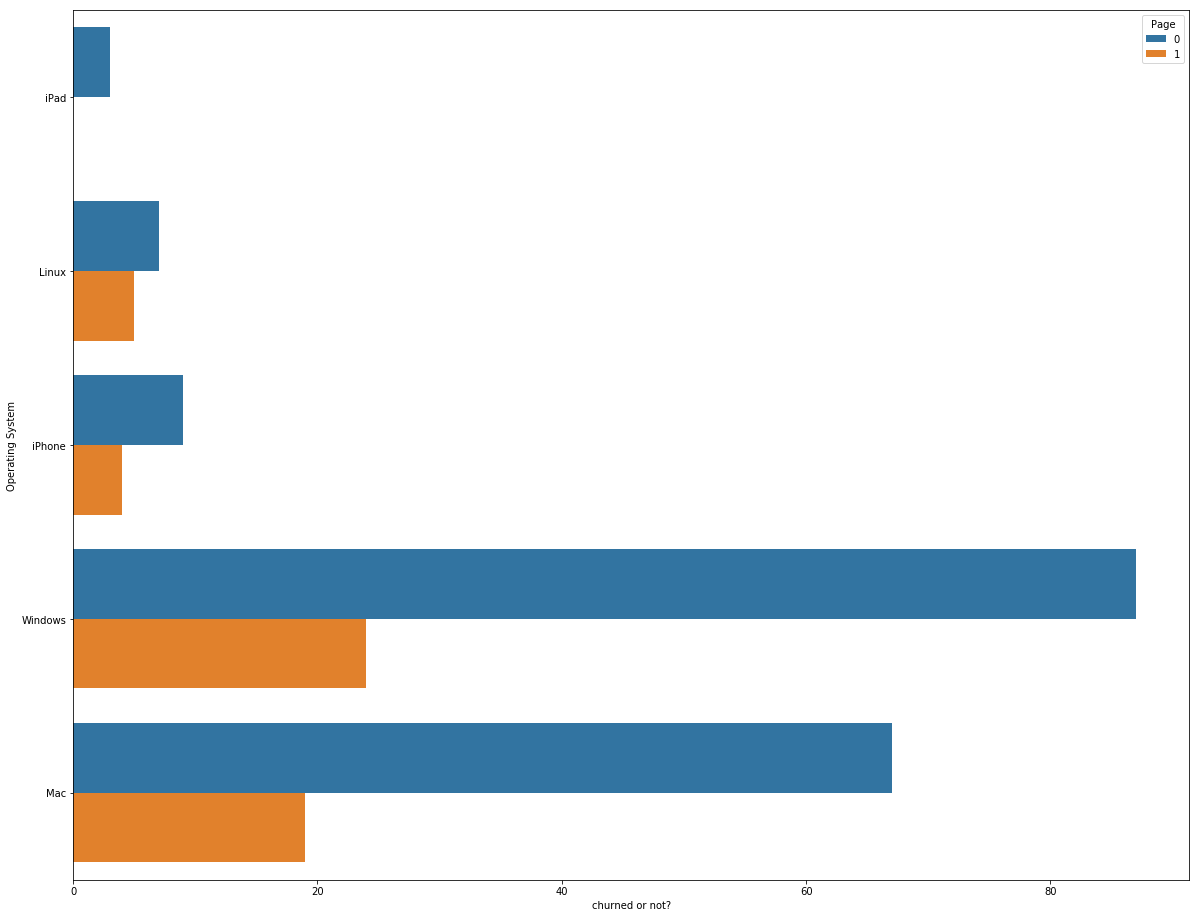

In [23]:
df_system_count = df_system.select(['userId', 'churn', 'operating_system']).dropDuplicates().groupby(["churn", "operating_system"]).count().toPandas()


plt.figure(figsize=[20,16])

ax_System = sns.barplot(x='count', y='operating_system', hue='churn', data=df_system_count)
plt.xlabel('churned or not?')
plt.ylabel('Operating System')
plt.legend(title='Page', loc='best')


i don't see here any diffrent between operating systems used so this feature doesn't interest us in building the model

Text(0,0.5,'Count')

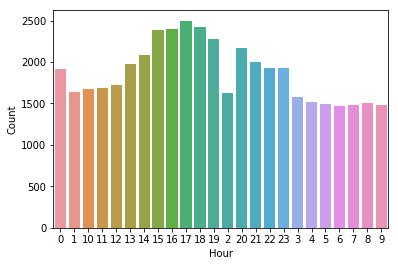

In [24]:
# now we wanna see how many hours used, by striping from the timestamp

strp_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

df_churn = df_churn.withColumn("Hour", strp_hour(df_churn.ts))

Hour_churn = df_churn.filter(df_churn.churn == 1).groupby(["Hour"]).count().toPandas().sort_values(by = "count", ascending = False)

ax_Hours_churn = sns.barplot(x='Hour', y='count', data=Hour_churn)
plt.xlabel('Hour')
plt.ylabel('Count')


Text(0,0.5,'Count')

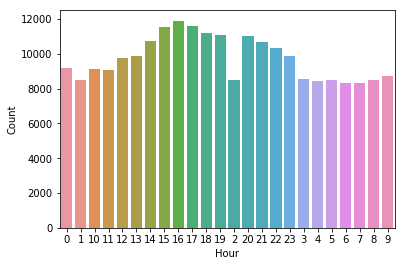

In [25]:
Hour_NotChurn = df_churn.filter(df_churn.churn == 0).groupby(["Hour"]).count().toPandas().sort_values(by = "count", ascending = False)

ax_Hours_Notchurn = sns.barplot(x='Hour', y='count', data=Hour_NotChurn)
plt.xlabel('Hour')
plt.ylabel('Count')
#plt.legend(title='Page', loc='best')


it appears that from the plots above,the churn users or not has similarity in terms of ditributions for hours, so it makes no diffrence if it churn or not.

+------+------------------+
|userId|        avg(count)|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
+------+------------------+
only showing top 5 rows

+-----------------+
|  avg(avg(count))|
+-----------------+
|70.78971233958933|
+-----------------+



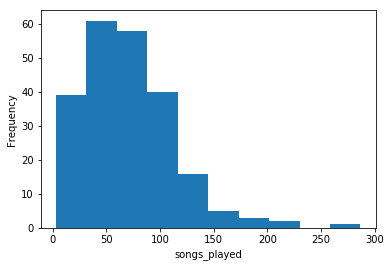

In [26]:
# How many song played this user? , we need this in order to build our model

num_song_played =df_churn.filter(df_churn.page == "NextSong").select(["song","userId","sessionId"]).groupby("userId","sessionId").count()

# now we will get the average song played per user 

avg_num_song_played = num_song_played.groupby("userId").agg({"count":"avg"})
avg_num_song_played.show(5)

#bin_edges = np.arange (10, avg_num_song_played['count'].max()+25, 25)
plt.hist(data = avg_num_song_played.toPandas(), x = 'avg(count)')
#plt.xlim(0,700)
plt.xlabel('songs_played')
plt.ylabel('Frequency');
num_song_played.groupby("userId").agg({"count":"avg"}).agg({"avg(count)":"avg"}).show()

Here we see from the plot and statistics above that users have an average of 70.79 songs listened to while using the platform, also i observe that there's some outliers.

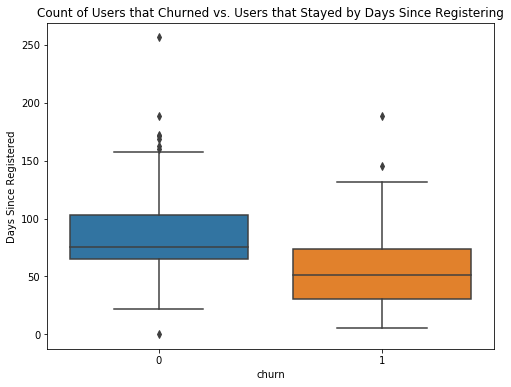

In [27]:
# since when the user been registered (in days)

days_registered = df_churn.select('userId','ts','registration','churn').withColumn(
    'days_member',((df_churn.ts - df_churn.registration)/1000/3600/24)).groupBy('userId','churn').agg(
    {'days_member':'max'}).withColumnRenamed('max(days_member)','days_member') 

days_registered = days_registered.toPandas()

plt.figure(figsize=[8,6])
sns.boxplot(data = days_registered, x = 'churn', y ='days_member')
plt.title('Count of Users that Churned vs. Users that Stayed by Days Since Registering')
plt.ylabel("Days Since Registered");

We see here that when the user are registered for a long time it stays loyal to the platform

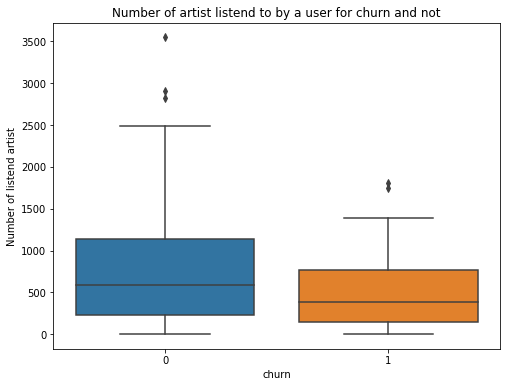

In [28]:
# let's now work on the number of listened artist for each user

Artist_count = df_churn.select('userId', 'artist','churn').dropDuplicates().groupby('churn','userId').count().toPandas()

Artist_count.groupby('churn').mean()

plt.figure(figsize=[8,6])
sns.boxplot(data = Artist_count, x = 'churn', y ='count')
plt.title('Number of artist listend to by a user for churn and not')
plt.ylabel("Number of listend artist");

I see that there's a big diffrence between the two so difenetley we will be adding this feature to our model.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### After Exploring some data, we can now take the features (Variables) we need in order to build our data before modeling part.

### The Variables we will be using for building our model is mentioned below:
   #### 1.Gender (Categorical)
   #### 2.Level (Categorical)
   #### 3.Avg. of songs listend to by a user. (Numerical)
   #### 4.Number of days since registered. (Numerical)
   #### 5.Page Actions which have 6 Features will be added (HomeAction,AddToPlaylist,AddFriend,ThumbsUp,ThumbsDown,RollAdvert) All Numerical
   #### 6.Num of artist listened to by a user (Numerical)

In [29]:
# the first feature will be the gender 

gender_col = df_churn.select('gender','userId').dropDuplicates().toPandas()

#gender_col = gender_col.replace('M', '1', 'gender')
#gender_col = gender_col.replace('F', '0', 'gender')
gender_col['gender'] = gender_col['gender'].replace("M", 1)
gender_col['gender'] = gender_col['gender'].replace("F", 0)
gender_col.head()
#gender_col.show(10)

,gender,userId
0,0,100008
1,1,38
2,0,154
3,0,200021
4,0,36


In [30]:
# the second feature will be the level, we need the latest value so we will be sorting by the date then take the latest value

level_col = df_churn.select('level','userId', 'ts').toPandas().sort_values(by='ts').drop_duplicates('userId', keep='last')

level_col['level'] = level_col['level'].replace("paid", 1)
level_col['level'] = level_col['level'].replace("free", 0)
level_col = level_col.drop('ts', axis = 1)
level_col.head()



,level,userId
207726,0,100011
208142,0,100001
10588,0,135
209036,0,100024
243819,1,300007


In [31]:
# our third feature would be the Avg number of songs which is ready and we did make this feature ready in the exploration part
# we just now to make a cleaning and transforming step

avg_num_songs = avg_num_song_played.toPandas().rename(columns = {'avg(count)' : 'avg_num_songs'})

avg_num_songs.head(10)

,userId,avg_num_songs
0,100010,39.285714
1,200002,64.500000
2,125,8.000000
3,51,211.100000
4,124,145.678571
5,7,21.428571
6,54,81.171429
7,15,136.714286
8,155,136.666667
9,100014,42.833333


In [32]:
# now for the next feature it would be the Days since Registered for each user , it is a numeric feature
days_registered = days_registered.drop('churn', axis = 1)
days_registered.head(10)

,userId,days_member
0,100010,55.643657
1,200002,70.074630
2,125,71.316887
3,124,131.555914
4,51,19.455845
5,7,72.778183
6,15,56.513576
7,54,110.751690
8,155,23.556019
9,100014,85.083403


In [33]:
# now we want to make some features from the 'page' column
# as we say earlier in the exploration part for the page,
# some of the actions appears to be affect weather user have churn or not.
# these actions are "Home","roll advert", "added to playlist" , "thumps down", "thumps up", and "friend added"

# first let's select the page column

Actions_df = df_churn.select('page','userId').toPandas()
Actions_df.head()

,page,userId
0,NextSong,30
1,NextSong,9
2,NextSong,30
3,NextSong,9
4,NextSong,30


In [34]:
# next we use the get_dummies function which makes everything easy for us

Actions_df = pd.get_dummies(Actions_df,columns=['page'], prefix='Action_')

In [35]:
# then we select the columns we need after pivoting the value to columns

Actions_df_final = Actions_df.loc[:, ['userId','Action__Add to Playlist', 'Action__Add Friend','Action__Thumbs Down',
                             'Action__Thumbs Up', 'Action__Home','Action__Roll Advert']]

Actions_df_final.head()


,userId,Action__Add to Playlist,Action__Add Friend,Action__Thumbs Down,Action__Thumbs Up,Action__Home,Action__Roll Advert
0,30,0,0,0,0,0,0
1,9,0,0,0,0,0,0
2,30,0,0,0,0,0,0
3,9,0,0,0,0,0,0
4,30,0,0,0,0,0,0


In [36]:
Actions_df_final = Actions_df_final.groupby('userId').sum().reset_index()


Actions_df_final.head(10)
#Actions_df_final[Actions_df_final['userId'] == "200002"]

,userId,Action__Add to Playlist,Action__Add Friend,Action__Thumbs Down,Action__Thumbs Up,Action__Home,Action__Roll Advert
0,10,9.0,12.0,4.0,37.0,30.0,1.0
1,100,61.0,49.0,27.0,148.0,105.0,25.0
2,100001,3.0,2.0,2.0,8.0,11.0,14.0
3,100002,5.0,1.0,0.0,5.0,6.0,3.0
4,100003,2.0,0.0,0.0,3.0,7.0,9.0
5,100004,23.0,19.0,11.0,35.0,66.0,86.0
6,100005,3.0,3.0,3.0,7.0,15.0,18.0
7,100006,1.0,4.0,2.0,2.0,2.0,3.0
8,100007,9.0,17.0,6.0,19.0,20.0,5.0
9,100008,30.0,17.0,6.0,37.0,24.0,20.0


In [37]:
# now for the final feature we worked on it in the exploration part which is the number of artist listend to by a user
#drop('b', axis=1)
Artist_Count = Artist_count.rename(columns = {'count' : 'Artist_Count'})

Artist_Count.head(10)

,churn,userId,Artist_Count
0,0,100010,253
1,0,200002,340
2,1,125,9
3,0,124,2233
4,1,51,1386
5,0,7,143
6,0,15,1303
7,1,54,1745
8,0,155,644
9,1,100014,234


In [38]:
# now we will merge all the features with our outcome variable which will be the churn

data_frames = [Artist_Count,Actions_df_final,gender_col,level_col,days_registered,avg_num_songs]

df_final = ft.reduce(lambda left, right: pd.merge(left, right, on='userId'), data_frames)\


df_final.head()

,churn,userId,Artist_Count,Action__Add to Playlist,Action__Add Friend,Action__Thumbs Down,Action__Thumbs Up,Action__Home,Action__Roll Advert,gender,level,days_member,avg_num_songs
0,0,100010,253,7.0,4.0,5.0,17.0,11.0,52.0,0,0,55.643657,39.285714
1,0,200002,340,8.0,4.0,6.0,21.0,20.0,7.0,1,1,70.074630,64.500000
2,1,125,9,0.0,0.0,0.0,0.0,0.0,1.0,1,0,71.316887,8.000000
3,0,124,2233,118.0,74.0,41.0,171.0,176.0,4.0,0,1,131.555914,145.678571
4,1,51,1386,52.0,28.0,21.0,100.0,75.0,0.0,1,1,19.455845,211.100000


In [39]:
df_final = df_final.drop('userId', axis = 1)

df_final.apply(pd.to_numeric)

df_final = (spark.createDataFrame(df_final))

df_final.show(10)

+-----+------------+-----------------------+------------------+-------------------+-----------------+------------+-------------------+------+-----+------------------+------------------+
|churn|Artist_Count|Action__Add to Playlist|Action__Add Friend|Action__Thumbs Down|Action__Thumbs Up|Action__Home|Action__Roll Advert|gender|level|       days_member|     avg_num_songs|
+-----+------------+-----------------------+------------------+-------------------+-----------------+------------+-------------------+------+-----+------------------+------------------+
|    0|         253|                    7.0|               4.0|                5.0|             17.0|        11.0|               52.0|     0|    0|  55.6436574074074|39.285714285714285|
|    0|         340|                    8.0|               4.0|                6.0|             21.0|        20.0|                7.0|     1|    1| 70.07462962962963|              64.5|
|    1|           9|                    0.0|               0.0|       

In [40]:
df_final.printSchema()


root
 |-- churn: long (nullable = true)
 |-- Artist_Count: long (nullable = true)
 |-- Action__Add to Playlist: double (nullable = true)
 |-- Action__Add Friend: double (nullable = true)
 |-- Action__Thumbs Down: double (nullable = true)
 |-- Action__Thumbs Up: double (nullable = true)
 |-- Action__Home: double (nullable = true)
 |-- Action__Roll Advert: double (nullable = true)
 |-- gender: long (nullable = true)
 |-- level: long (nullable = true)
 |-- days_member: double (nullable = true)
 |-- avg_num_songs: double (nullable = true)



In [41]:
# now we want to use the vectiorassembler function to put all column in one vector
# then using standardscaler to scale all features as shown below.

assembler = VectorAssembler(inputCols=df_final.columns[1:],outputCol = "vector_features")
df_final = assembler.transform(df_final)




In [42]:

scaler = StandardScaler(inputCol="vector_features", outputCol="scaled_features", withStd=True)
scalerModel = scaler.fit(df_final)
df_final = scalerModel.transform(df_final)


In [43]:
df_final.head()

Row(churn=0, Artist_Count=253, Action__Add to Playlist=7.0, Action__Add Friend=4.0, Action__Thumbs Down=5.0, Action__Thumbs Up=17.0, Action__Home=11.0, Action__Roll Advert=52.0, gender=0, level=0, days_member=55.6436574074074, avg_num_songs=39.285714285714285, vector_features=DenseVector([253.0, 7.0, 4.0, 5.0, 17.0, 11.0, 52.0, 0.0, 0.0, 55.6437, 39.2857]), scaled_features=DenseVector([0.4189, 0.214, 0.1943, 0.3823, 0.2596, 0.2326, 2.413, 0.0, 0.0, 1.4775, 0.9219]))

As we Can see above the column scaled_features is now transformed so we can use it as featuers in building the model step.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

Now after we did some preprocessing and our features are setup, we are now ready to build the models we will first split the data into training and testing, then build the model and choosing our best model, after that tuning parameter for our best model, then to show features importance, finally showing the result and recommendations.

In [44]:
# Split the data into training, testing, and validation sets
(train_df, test_df, validation_df) = df_final.randomSplit([0.6, 0.2, 0.2])

# Create a list of models 

lgr = LogisticRegression(featuresCol = "scaled_features", labelCol = "churn")
svm = LinearSVC(featuresCol = 'scaled_features', labelCol = 'churn')
gbt = GBTClassifier(featuresCol = 'scaled_features', labelCol = 'churn')
rndmf = RandomForestClassifier(featuresCol = 'scaled_features', labelCol = 'churn')
nvb = NaiveBayes(featuresCol = 'scaled_features', labelCol = 'churn')


The result shows that the best model is  , so we will do next Model Tuning in order to get the best result.

In [45]:
# lets get train our models then get the results

# Logistic_Regression
import pyspark.ml.classification as classification
import pyspark.ml.evaluation as evaluation

evaluator = MulticlassClassificationEvaluator(labelCol = 'churn', predictionCol='prediction')

Model_lgr = lgr.fit(train_df)
predictions_lgr = Model_lgr.transform(test_df)


# Random Forrest

Model_rndmf = rndmf.fit(train_df)
predictions_rndmf = Model_rndmf.transform(test_df)

# SVM

Model_svm = svm.fit(train_df)
predictions_svm = Model_svm.transform(test_df)

# Naive Bayes

Model_nvb = nvb.fit(train_df)
predictions_nvb = Model_nvb.transform(test_df)

#Gradient-Boosted Trees

Model_gbt = gbt.fit(train_df)
predictions_gbt = Model_gbt.transform(test_df)



In [46]:
print("Logistic Regression Accuracy:",evaluator.evaluate(predictions_lgr, {evaluator.metricName: "accuracy"}),
      "Logistic Regression F1:",evaluator.evaluate(predictions_lgr, {evaluator.metricName: "f1"}),
      "Random Forrest Accuracy:",evaluator.evaluate(predictions_rndmf, {evaluator.metricName: "accuracy"}),
      "Random Forrest F1:",evaluator.evaluate(predictions_rndmf, {evaluator.metricName: "f1"}),
      "SVM Accuracy:",evaluator.evaluate(predictions_svm, {evaluator.metricName: "accuracy"}),
      "SVM F1:",evaluator.evaluate(predictions_svm, {evaluator.metricName: "f1"}),
      "Naive Bayes Accuracy:",evaluator.evaluate(predictions_nvb, {evaluator.metricName: "accuracy"}),
      "Naive Bayes F1:",evaluator.evaluate(predictions_nvb, {evaluator.metricName: "f1"}),
      "Gradient-Boosted Trees Accuracy:",evaluator.evaluate(predictions_gbt, {evaluator.metricName: "accuracy"}),
      "Gradient-Boosted Trees F1:",evaluator.evaluate(predictions_gbt, {evaluator.metricName: "accuracy"})
      )


Logistic Regression Accuracy: 0.7954545454545454 Logistic Regression F1: 0.7653615041674744 Random Forrest Accuracy: 0.7272727272727273 Random Forrest F1: 0.679144385026738 SVM Accuracy: 0.6590909090909091 SVM F1: 0.5236612702366127 Naive Bayes Accuracy: 0.6590909090909091 Naive Bayes F1: 0.5236612702366127 Gradient-Boosted Trees Accuracy: 0.7272727272727273 Gradient-Boosted Trees F1: 0.7272727272727273


We Can see above that the best model is the Logistic Regression with an accuracy 79%  and F1 0.75

In [47]:
# Model Tuning
#Model_lgr.regParam

paramgrid =ParamGridBuilder()\
.addGrid(lgr.regParam, [0.0, 0,1])\
.addGrid(lgr.maxIter, [10])\
.build()


In [48]:
evaluator_lr = MulticlassClassificationEvaluator(labelCol = 'churn', predictionCol='prediction')

crossval = CrossValidator(estimator=lgr,
                          estimatorParamMaps=paramgrid,
                          evaluator=evaluator_lr,
                          numFolds=3)


In [49]:
cvModel = crossval.fit(train_df)


# Make predictions on Validation data

BestModel_lgr = cvModel.transform(validation_df)



In [50]:
print("Logistic Regression Accuracy:",evaluator_lr.evaluate(BestModel_lgr, {evaluator_lr.metricName: "accuracy"}),
      "Logistic Regression F1:",evaluator_lr.evaluate(BestModel_lgr, {evaluator_lr.metricName: "f1"}))

Logistic Regression Accuracy: 0.8235294117647058 Logistic Regression F1: 0.7852941176470587


### Feature Importance

Now we want to see from the features who is the more important one

In [78]:
BestModel = cvModel.bestModel
feature_importance = BestModel.featureImportances


# i don't know why there's an error here


AttributeError: 'LogisticRegressionModel' object has no attribute 'featureImportances'


## Conclusions

As we say earlier first we took a look exploration on the small data after the EDA part we choosed our Features then we preprocessed our columns in order to get the data ready for modeling the the we fitted multiple algorithms we finally our winner model was the logisitic regression then we did some tuning for the model and we got oure result which is the Accuracy was : 82% and the F1 was: 0.78 which is considered good results.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.